# Reliability model quay walls (Port of Merak as case study)

In [5]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("default")

## Input parameters and their probabilistic distributions

In [6]:
N = 10000 #Number of runs Monte Carlo analysis
zeros = np.zeros(N)

#HEIGTS i.r.t LAT!


#Loads
SLR_mean = 0 # [m]
Hwaves_mean = 1.0 # [m]

#waterlevels

hw_mean = 10 # [m]
HAT_mean = 1 # [m]
MSL_mean = 0.53 # [m]
hcrest_mean = 3.1 # [m]
DWL_mean = 1.5 # [m]

#other parameters
Tm1_mean = 3.8 # [s]
g_mean = 9.81 # [m/s^2]
RAO_sway_mean = 0.88 # [-] Extracted from file 'RAO_values_Merak'
RAO_heave_mean = 1.1 # [-] Extracted from file 'RAO_values_Merak'
RAO_roll_mean = 0.32 # [-] Extracted from file 'RAO_values_Merak'


#guidelines (resistance terms limit state functions)
overtopping_R = 5 # [l/s/m]
Sway_R = 2 # [m]
Heave_R = 2 # [m]
Roll_R = 1 # [degrees]
Mooring_R = 2400  # [kN]

#ship characteristics (hypothetical ship arriving at the Port of Merak)
Bship_mean = 19.6 # [m]
Lship_mean = 128 # [m]
Hship_mean = 8.4 # [m]
Tship_mean = 5.8 # [m]
rhow_mean = 10.25 # [kN/m^3]
Cmy_mean = 0.4 # [-]


#Distributions
hcrest = scipy.stats.norm(hcrest_mean, 0.05*hcrest_mean).rvs(N)
DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
hw = scipy.stats.norm(hw_mean, 0.05*hw_mean).rvs(N)
Tm1 = scipy.stats.norm(Tm1_mean, 0.05*Tm1_mean).rvs(N)
g = scipy.stats.norm(g_mean, 0.0).rvs(N)
RAO_sway = scipy.stats.norm(RAO_sway_mean, 0.05*RAO_sway_mean).rvs(N)
RAO_heave = scipy.stats.norm(RAO_heave_mean, 0.05*RAO_heave_mean).rvs(N)
RAO_roll = scipy.stats.norm(RAO_roll_mean, 0.05*RAO_roll_mean).rvs(N)
overtopping = scipy.stats.norm(overtopping_R, 0.05*overtopping_R).rvs(N)
sway = scipy.stats.norm(Sway_R, 0.05*Sway_R ).rvs(N)
heave = scipy.stats.norm(Heave_R, 0.05*Heave_R).rvs(N)
roll = scipy.stats.norm(Roll_R , 0.05*Roll_R ).rvs(N)
Bship = scipy.stats.norm(Bship_mean , 0.05*Bship_mean).rvs(N)
Lship = scipy.stats.norm(Lship_mean , 0.05*Lship_mean).rvs(N)
Hship = scipy.stats.norm(Hship_mean , 0.05*Hship_mean).rvs(N)
Tship = scipy.stats.norm(Tship_mean , 0.05*Tship_mean).rvs(N)
rhow = scipy.stats.norm(rhow_mean , 0.01*rhow_mean ).rvs(N)
Cmy = scipy.stats.lognorm(Cmy_mean , 0.15*Cmy_mean ).rvs(N)
mooring = scipy.stats.norm(Mooring_R, 0.05*Mooring_R ).rvs(N)

In [7]:
def Overflow(Tm1, hw, hcrest,DWL_mean, Hwaves_mean, SLR_mean):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
    Lm1 = (g*Tm1**2) / (2*np.pi)
    k = (2*np.pi) / Lm1
    h0 = 0.5*k*Hwaves**2*(1/np.tanh(k*hw))
    R_overflow = hcrest
    S_overflow = DWL + SLR +h0
    LS_overflow = R_overflow - S_overflow
    return LS_overflow

def Overtopping(hw, overtopping, hcrest, Tm1, Hwaves_mean, SLR_mean, DWL_mean):
    SLR = scipy.stats.norm(SLR_mean, 0.05*SLR_mean).rvs(N)
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    DWL = scipy.stats.norm(DWL_mean, 0.05*DWL_mean).rvs(N)
    Rc = hcrest - DWL - SLR
    Lm1 = (g*Tm1**2) / (2*np.pi)
    h_impuls = (hw/Hwaves)*((2*np.pi*hw)/(g*Tm1**2))
    sm1 = Hwaves / Lm1 
    if np.nanmean(h_impuls) > 0.23:
        S_overtopping = (((g*Hwaves**3)**0.5)*(0.023)*np.exp(-2.7*Rc/Hwaves))*1000
    elif np.nanmean(h_impuls) < 0.23 and np.nanmean(Rc)/np.nanmean(Hwaves) < 1.35:
        S_overtopping = (((g*Hwaves**3)**0.5)*(0.011)*((Hwaves/(hw*sm1))**0.5)*np.exp(-2.2*Rc/Hwaves))*1000
    elif np.nanmean(h_impuls) < 0.23 and np.nanmean(Rc)/np.nanmean(Hwaves) > 1.35:
        S_overtopping = (((g*Hwaves**3)**0.5)*(0.011)*((Hwaves/(hw*sm1))**0.5)*(-2.2*Rc/Hwaves)**-3)*1000
    R_overtopping = overtopping
    LS_overtopping = R_overtopping - S_overtopping 
    return LS_overtopping

def Impact(hw, Hwaves_mean, Tm1, g): #failure due to wave impact
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    h_impuls = (hw/Hwaves)*((2*np.pi*hw)/(g*Tm1**2))
    if np.nanmean(h_impuls) > 0.23:
        S_impuls = -1
    else:
        S_impuls = 1
    LS_impact = -S_impuls
    return LS_impact


def DOF_heave(Hwaves_mean, RAO_heave, heave): #Failure due to heave exceeding threshold limits
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    heave_S = Hwaves * RAO_heave
    LS_heave = heave - heave_S
    return LS_heave

def DOF_sway(Hwaves_mean , RAO_sway, sway): #Failure due to sway exceeding threshold limits
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    sway_S = Hwaves*RAO_sway
    LS_sway = sway - sway_S
    return LS_sway

def DOF_roll(Hwaves_mean, RAO_roll, roll): #Failure due to roll exceeding threshold limits
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    roll_S = Hwaves*RAO_roll
    LS_roll = roll - roll_S
    return LS_roll

def DOF_Mooringforces(Hwaves_mean,hw,Tm1, Bship,Lship,Tship,Hship,rhow, Cmy,mooring): #Failure due to mooring forces exceeding threshold limits
    Hwaves = scipy.stats.norm(Hwaves_mean, 0.05*Hwaves_mean).rvs(N)
    Lm1 = (g*Tm1**2) / (2*np.pi)
    F1 = np.sinh(2*np.pi*hw/Lm1)
    F2 = np.sinh(2*np.pi*((hw-Tship)/Lm1))
    F3 = np.cosh(2*np.pi*hw/Lm1)
    Mooring_S = Cmy *((F1-F2)/F3)*((np.pi*np.sin(90))/8)*Bship**2*rhow*Hwaves
    Mooring_R = mooring
    LS_mooring = Mooring_R - Mooring_S
    return LS_mooring

N_overflow = np.less_equal(Overflow(Tm1, hw, hcrest,DWL_mean, Hwaves_mean, SLR_mean), zeros)
N_overtopping = np.less_equal(Overtopping(hw, overtopping, hcrest, Tm1, Hwaves_mean, SLR_mean, DWL_mean), zeros)
N_Impact = np.less_equal(Impact(hw, Hwaves_mean, Tm1, g), zeros)
N_heave = np.less_equal(DOF_heave(Hwaves_mean, RAO_heave, heave), zeros)
N_sway = np.less_equal(DOF_sway(Hwaves_mean , RAO_sway, sway), zeros)
N_roll = np.less_equal(DOF_roll(Hwaves_mean, RAO_roll, roll), zeros)
N_mooring = np.less_equal(DOF_Mooringforces(Hwaves_mean,hw,Tm1, Bship,Lship,Tship,Hship,rhow, Cmy,mooring), zeros)
N_motions = N_sway + N_heave + N_roll

failure_overflow = np.sum(N_overflow) / float(N)
failure_overtopping = np.sum(N_overtopping) / float(N)
failure_impact = np.sum(N_Impact) / float(N)
failure_heave = np.sum(N_heave) / float(N)
failure_sway = np.sum(N_sway) / float(N)
failure_roll = np.sum(N_roll) / float(N)
failure_mooring = np.sum(N_mooring) / float(N)

#Failure due to motions (combining heave,sway and roll)
Pf_motions = 1-((1-failure_heave)*(1-failure_sway)*(1-failure_roll))

Pf_upper = failure_overflow+failure_overtopping+failure_impact + Pf_motions +  failure_mooring
if Pf_upper > 1.0:
    Pf_upper= 1.0
Pf_independent = 1-((1-failure_overflow)*(1-failure_overtopping)*(1-failure_impact)*(1-Pf_motions)*(1-failure_mooring))
Pf_lower = np.max([failure_overflow, failure_overtopping, failure_impact, Pf_motions, failure_mooring])

pd.set_option('display.float_format', lambda x: '%.5f' % x)
d = { 'Failure mechanism': ['overflow', 'overtopping', 'wave impact', 'DOF motions', 'Mooring forces','Quay wall (Upper bound)', 'Quay wall (independent)', 'Quay wall (Lower bound)' ], 
     'Pf': [failure_overflow, failure_overtopping, failure_impact, Pf_motions, failure_mooring, Pf_upper, Pf_independent, Pf_lower]}
df = pd.DataFrame(data=d)
df


,Failure mechanism,Pf
0,overflow,0.00000
1,overtopping,0.00050
2,wave impact,0.00000
3,DOF motions,0.00000
4,Mooring forces,0.04360
5,Quay wall (Upper bound),0.04410
6,Quay wall (independent),0.04408
7,Quay wall (Lower bound),0.04360


## Monte Carlo analysis loop (fragility curves) 

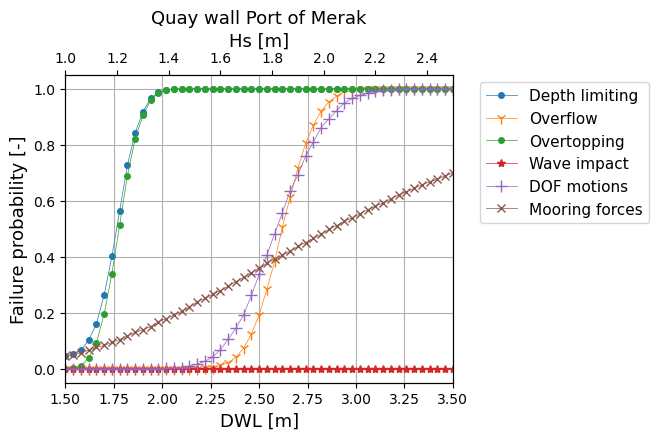

<Figure size 500x400 with 0 Axes>

In [8]:
N_vertical = 50 # Number of values on the horizontal axis 
# empty lists which are filled with conditional failure probabilities when subjected to increased hydraulic loading
list_total = []
list_overtopping = []
list_overflow = []
list_impact = []
list_DOF = []
list_mooring = []


#Min and max values for the different loads
SLR_max = 2 
SLR_min = 0

Hwaves_max = 3 # offshore wave heigth
Hwaves_min = 0.5


SLR_range =np.arange(SLR_min,1.001*SLR_max ,(SLR_max-SLR_min)/N_vertical)
Hwaves_range = np.arange(Hwaves_min,1.001*Hwaves_max,(Hwaves_max-Hwaves_min)/N_vertical)
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)


#Choose type of hydraulic loading which will gradually increase
# 1 = rising water levels (sea level rise)
# 2 = rising wave height
# 3 = combination of both when incoming waves are depth-limited

x = 3


if x == 1:
    a = SLR_range
    c = scipy.stats.norm(Hwaves_mean, 0.0).rvs(N)
    d = a + DWL_mean
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    title = 'Pf vs DWL' 
    xas = 'DWL [m]'
    yas = 'Probability of failure (Pf)'
elif x == 2:
    a = scipy.stats.norm(SLR_mean, 0.0).rvs(N)
    c = Hwaves_range
    d = c 
    ax1.set_xlim(Hwaves_min,  Hwaves_max)
    title = 'Pf vs Hs'
    xas = 'Hs [m]'
    yas = 'Probability of failure (Pf)'
elif x == 3:
    DWL = scipy.stats.norm(DWL_mean, 0.0*DWL_mean).rvs(N)
    a = SLR_range 
    c =  (Hwaves_mean + 0.75*SLR_range)
    d = a + DWL_mean
    title = 'Quay wall Port of Merak'
    xas = 'DWL [m]'
    yas = 'Failure probability [-]'
    ax2 = ax1.twiny()
    ax1.set_xlim(DWL_mean, SLR_max + DWL_mean)
    ax2.set_xlim(Hwaves_mean, (Hwaves_mean + 0.75*SLR_max))
    ax2.set_xlabel('Hs [m]', size = 13)


for i in range(len(d)):
    SLR_mean = a[i]
    Hwaves_mean = c[i]
    
    failure_overflow = np.sum(np.less_equal(Overflow(Tm1, hw, hcrest,DWL_mean, Hwaves_mean, SLR_mean), zeros)) / float(N)
    failure_overtopping = np.sum(np.less_equal(Overtopping(hw, overtopping, hcrest, Tm1, Hwaves_mean, SLR_mean, DWL_mean), zeros)) / float(N)
    failure_impact = np.sum(np.less_equal(Impact(hw, Hwaves_mean, Tm1, g), zeros)) / float(N)
    failure_heave = np.sum(np.less_equal(DOF_heave(Hwaves_mean, RAO_heave, heave), zeros)) / float(N)
    failure_sway = np.sum(np.less_equal(DOF_sway(Hwaves_mean , RAO_sway, sway), zeros)) / float(N)
    failure_roll = np.sum(np.less_equal(DOF_roll(Hwaves_mean, RAO_roll, roll), zeros)) / float(N)
    failure_mooring = np.sum(np.less_equal(DOF_Mooringforces(Hwaves_mean,hw,Tm1, Bship,Lship,Tship,Hship,rhow, Cmy,mooring), zeros)) / float(N)
    failure_total = 1-((1-failure_overflow)*(1-failure_overtopping)*(1-failure_impact)*(1-Pf_motions)*(1-failure_mooring))
    Pf_motions = 1-((1-failure_heave)*(1-failure_sway)*(1-failure_roll))
    
    list_overtopping.append(failure_overtopping)
    list_overflow.append(failure_overflow)
    list_impact.append(failure_impact)
    list_DOF.append(Pf_motions)
    list_mooring.append(failure_mooring)
    list_total.append(failure_total)
   
    
plt.figure(figsize=(5,4))

ax1.plot(d,list_total, label ='Depth limiting', linewidth = 0.5, marker ='.', markersize = '8')
ax1.plot(d,list_overflow, label ='Overflow',linewidth = 0.5, marker ='1', markersize = '8')
ax1.plot(d,list_overtopping, label = 'Overtopping', linewidth = 0.5, marker ='.', markersize = '8')
ax1.plot(d,list_impact, label = 'Wave impact', linewidth = 0.5, marker ='*', markersize = '6')
ax1.plot(d,list_DOF, label ='DOF motions', linewidth = 0.5, marker ='+', markersize = '8')
ax1.plot(d,list_mooring, label ='Mooring forces', linewidth = 0.5, marker ='x', markersize = '6')
ax1.set_title(title, size = 13)
ax1.grid()
ax1.set_ylabel(yas, size = 13)
ax1.set_xlabel(xas, size = 13)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 1, prop={"size":11})